In [1]:
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import metapredict as meta
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')

/opt/anaconda3/envs/jupyter_env/lib/python3.10/site-packages/alphaPredict/backend/parrot_alpha.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  brnn_network.load_state_

In [2]:
# Gathering all ENSTs to upload to zoonomia
TF_ENSTs = glob.glob("../soto_analysis/outputs/mutations/cds_bed_format/*")

In [3]:
SFARI_TF_ENSTs = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv")
SFARI_TF_ENSTs["ENST"] = SFARI_TF_ENSTs["ENST"].str.split(".").str[0]
SFARI_TF_ENSTs = SFARI_TF_ENSTs["ENST"]
SFARI_TF_ENSTs

0      ENST00000349014
1      ENST00000247087
2      ENST00000379044
3      ENST00000361283
4      ENST00000575354
            ...       
117    ENST00000366197
118    ENST00000393883
119    ENST00000601440
120    ENST00000276123
121    ENST00000508784
Name: ENST, Length: 122, dtype: object

In [4]:
# SFARI TF AD PhyloP Scores

ad_phylo_P = []

ENSTs = glob.glob("../soto_analysis/outputs/mutations/domains_zoonomia_all_TF_cds/*")
for ENST in ENSTs:
    if ENST.split("/")[-1].split(".")[0] in set(SFARI_TF_ENSTs):
        df = pd.read_csv(ENST, sep = "\t", header = None)
        ad_phylo_P.append(df)

ad_phylo_P = pd.concat(ad_phylo_P)
ad_phylo_P = ad_phylo_P.rename(columns = {7: "ENST", 16: "PhyloP"})
dbd_phylo_P = ad_phylo_P[ad_phylo_P[3] == "DBD"]
ad_phylo_P = ad_phylo_P[ad_phylo_P[3] == "AD"]
ad_phylo_P

,0,1,2,3,4,5,6,ENST,8,9,10,11,12,13,14,15,PhyloP
162,18,55461023,55461024,AD,NaN,.,-,ENST00000356073,18,55461023,55461024,ENST00000356073,-1,18,55461023,55461024,4.722
163,18,55461024,55461025,AD,NaN,.,-,ENST00000356073,18,55461024,55461025,ENST00000356073,-1,18,55461024,55461025,6.360
164,18,55461025,55461026,AD,NaN,.,-,ENST00000356073,18,55461025,55461026,ENST00000356073,-1,18,55461025,55461026,4.741
165,18,55461026,55461027,AD,NaN,.,-,ENST00000356073,18,55461026,55461027,ENST00000356073,-1,18,55461026,55461027,8.903
166,18,55461027,55461028,AD,NaN,.,-,ENST00000356073,18,55461027,55461028,ENST00000356073,-1,18,55461027,55461028,6.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,14,64260487,64260488,AD,NaN,.,-,ENST00000341099,14,64260487,64260488,ENST00000341099,-1,14,64260487,64260488,8.903
1241,14,64260488,64260489,AD,NaN,.,-,ENST00000341099,14,64260488,64260489,ENST00000341099,-1,14,64260488,64260489,5.936
1242,14,64260489,64260490,AD,NaN,.,-,ENST00000341099,14,64260489,64260490,ENST00000341099,-1,14,64260489,64260490,3.732
1243,14,64260490,64260491,AD,NaN,.,-,ENST00000341099,14,64260490,64260491,ENST00000341099,-1,14,64260490,64260491,4.772


In [5]:
cds_phylo_P = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_zoonomia_all_TF_cds/*")
for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    if ENST in set(ad_phylo_P["ENST"]):
        df = pd.read_csv(path, sep = "\t", header = None)
        cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {3: "ENST", 8: "PhyloP"})
cds_phylo_P

,0,1,2,ENST,4,5,6,7,PhyloP
0,18,55228225,55228226,ENST00000356073,-1,18,55228225,55228226,1.153
1,18,55228226,55228227,ENST00000356073,-1,18,55228226,55228227,6.303
2,18,55228227,55228228,ENST00000356073,-1,18,55228227,55228228,8.857
3,18,55228228,55228229,ENST00000356073,-1,18,55228228,55228229,6.303
4,18,55228229,55228230,ENST00000356073,-1,18,55228229,55228230,6.328
...,...,...,...,...,...,...,...,...,...
1588,14,64282981,64282982,ENST00000341099,-1,14,64282981,64282982,7.135
1589,14,64282982,64282983,ENST00000341099,-1,14,64282982,64282983,8.900
1590,14,64282983,64282984,ENST00000341099,-1,14,64282983,64282984,6.333
1591,14,64282984,64282985,ENST00000341099,-1,14,64282984,64282985,6.359


In [6]:
df_all = cds_phylo_P.merge(ad_phylo_P.drop_duplicates(), on=[0, 1, 2], 
                   how='left', indicator=True)
df_all

,0,1,2,ENST_x,4_x,5_x,6_x,7,PhyloP_x,3,...,8,9,10,11,12,13,14,15,PhyloP_y,_merge
0,18,55228225,55228226,ENST00000356073,-1,18,55228225,55228226,1.153,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,18,55228226,55228227,ENST00000356073,-1,18,55228226,55228227,6.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,18,55228227,55228228,ENST00000356073,-1,18,55228227,55228228,8.857,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,18,55228228,55228229,ENST00000356073,-1,18,55228228,55228229,6.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,18,55228229,55228230,ENST00000356073,-1,18,55228229,55228230,6.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117016,14,64282981,64282982,ENST00000341099,-1,14,64282981,64282982,7.135,AD,...,14,64282981.0,64282982.0,ENST00000341099,-1.0,14,64282981.0,64282982.0,7.135,both
117017,14,64282982,64282983,ENST00000341099,-1,14,64282982,64282983,8.900,AD,...,14,64282982.0,64282983.0,ENST00000341099,-1.0,14,64282982.0,64282983.0,8.900,both
117018,14,64282983,64282984,ENST00000341099,-1,14,64282983,64282984,6.333,AD,...,14,64282983.0,64282984.0,ENST00000341099,-1.0,14,64282983.0,64282984.0,6.333,both
117019,14,64282984,64282985,ENST00000341099,-1,14,64282984,64282985,6.359,AD,...,14,64282984.0,64282985.0,ENST00000341099,-1.0,14,64282984.0,64282985.0,6.359,both


In [7]:
df_cds_no_ad = df_all[df_all["_merge"] == "left_only"]
df_cds_no_ad

,0,1,2,ENST_x,4_x,5_x,6_x,7,PhyloP_x,3,...,8,9,10,11,12,13,14,15,PhyloP_y,_merge
0,18,55228225,55228226,ENST00000356073,-1,18,55228225,55228226,1.153,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,18,55228226,55228227,ENST00000356073,-1,18,55228226,55228227,6.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,18,55228227,55228228,ENST00000356073,-1,18,55228227,55228228,8.857,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,18,55228228,55228229,ENST00000356073,-1,18,55228228,55228229,6.303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,18,55228229,55228230,ENST00000356073,-1,18,55228229,55228230,6.328,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116572,14,64280067,64280068,ENST00000341099,-1,14,64280067,64280068,8.803,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116573,14,64280068,64280069,ENST00000341099,-1,14,64280068,64280069,-1.230,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116574,14,64280069,64280070,ENST00000341099,-1,14,64280069,64280070,8.803,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116575,14,64280070,64280071,ENST00000341099,-1,14,64280070,64280071,6.264,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


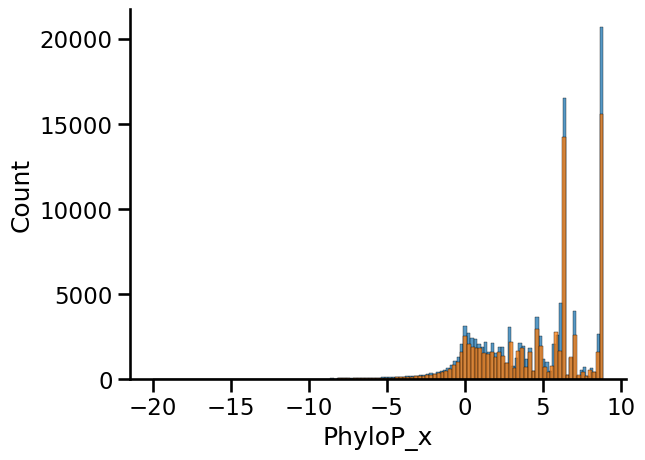

In [8]:
sns.histplot(data = df_all, x = "PhyloP_x")
sns.histplot(data = df_cds_no_ad, x = "PhyloP_x")
sns.despine();

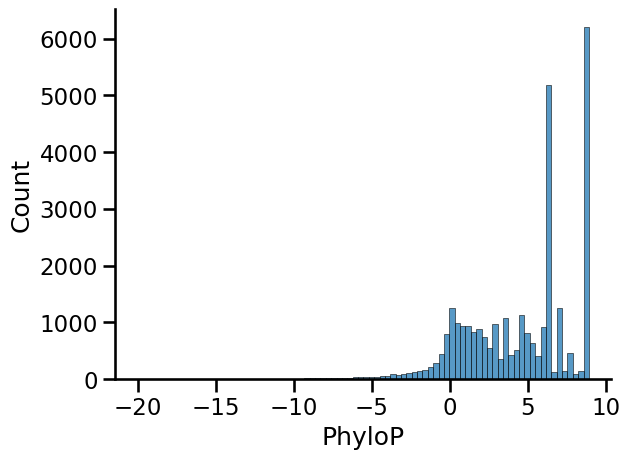

In [9]:
sns.histplot(data = ad_phylo_P, x = "PhyloP")
sns.despine();

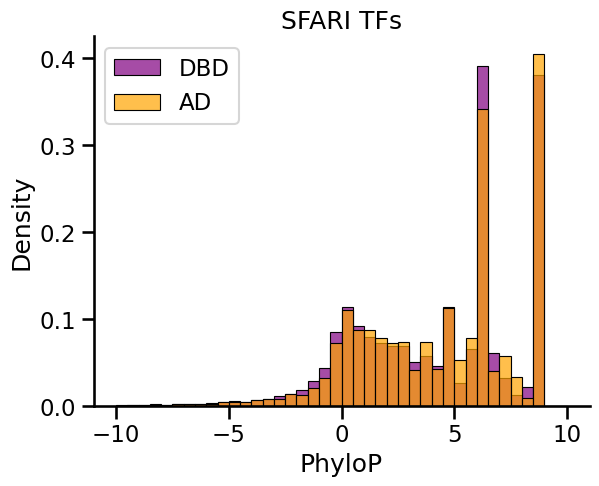

In [18]:
bins = np.arange(-10, 10.1, 0.5)
sns.set_context('talk')
#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plt.title("SFARI TFs")
plt.legend()
sns.despine();

In [19]:
def plot_mean(data, color, lw = 2):
    plt.axvline(data["PhyloP"].median(), color=color, ls='--', lw=lw)

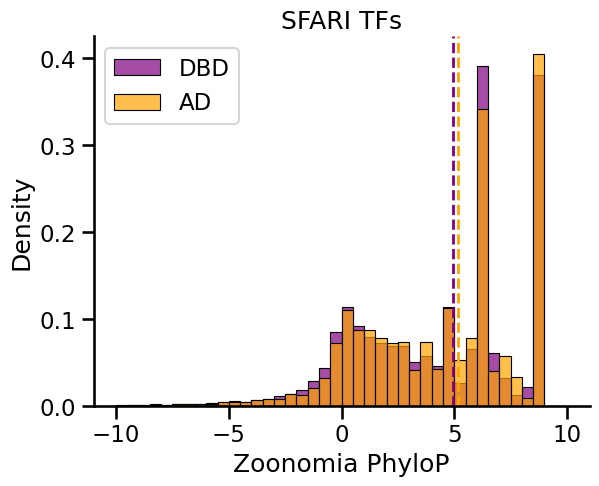

In [20]:
sns.set_context('talk')

bins = np.arange(-10, 10.1, 0.5)
#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
plot_mean(dbd_phylo_P, 'purple')

sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plot_mean(ad_phylo_P, 'orange')

plt.title("SFARI TFs")
plt.xlabel("Zoonomia PhyloP")
plt.legend()
sns.despine();

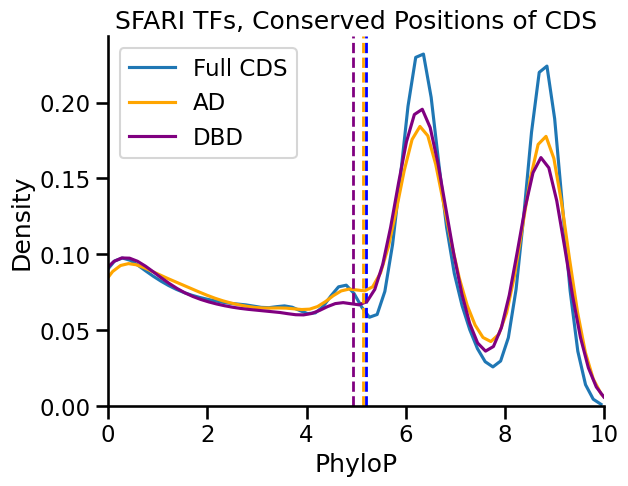

In [21]:
bins = np.arange(-10, 10.1, 0.5)
sns.kdeplot(data = cds_phylo_P, x = "PhyloP", label = "Full CDS")
plot_mean(cds_phylo_P, "b", lw = 2)

sns.kdeplot(data = ad_phylo_P, x = "PhyloP", color = "orange", label = "AD")
plot_mean(dbd_phylo_P, 'purple', lw = 2)

sns.kdeplot(data = dbd_phylo_P, x = "PhyloP", color = "purple", label = "DBD")
plot_mean(ad_phylo_P, 'orange', lw = 2)

plt.title("SFARI TFs, Conserved Positions of CDS")
plt.legend()
plt.xlim(0, 10)
sns.despine();

In [22]:
cds_phylo_P_to_merge = cds_phylo_P[[0, 1, 2,"ENST", 4, "PhyloP"]].copy(deep = True)
cds_phylo_P_to_merge = cds_phylo_P_to_merge.rename(columns = {4: 12})
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
0,18,55228225,55228226,ENST00000356073,-1,1.153
1,18,55228226,55228227,ENST00000356073,-1,6.303
2,18,55228227,55228228,ENST00000356073,-1,8.857
3,18,55228228,55228229,ENST00000356073,-1,6.303
4,18,55228229,55228230,ENST00000356073,-1,6.328
...,...,...,...,...,...,...
1588,14,64282981,64282982,ENST00000341099,-1,7.135
1589,14,64282982,64282983,ENST00000341099,-1,8.900
1590,14,64282983,64282984,ENST00000341099,-1,6.333
1591,14,64282984,64282985,ENST00000341099,-1,6.359


In [23]:
ad_phylo_P_to_merge = ad_phylo_P[[0, 1, 2, "ENST", 12, "PhyloP"]]
ad_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
162,18,55461023,55461024,ENST00000356073,-1,4.722
163,18,55461024,55461025,ENST00000356073,-1,6.360
164,18,55461025,55461026,ENST00000356073,-1,4.741
165,18,55461026,55461027,ENST00000356073,-1,8.903
166,18,55461027,55461028,ENST00000356073,-1,6.360
...,...,...,...,...,...,...
1240,14,64260487,64260488,ENST00000341099,-1,8.903
1241,14,64260488,64260489,ENST00000341099,-1,5.936
1242,14,64260489,64260490,ENST00000341099,-1,3.732
1243,14,64260490,64260491,ENST00000341099,-1,4.772


In [24]:
dbd_phylo_P_to_merge = dbd_phylo_P[[0, 1, 2, "ENST", 12, "PhyloP"]]
dbd_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP
0,18,55228860,55228861,ENST00000356073,-1,6.360
1,18,55228861,55228862,ENST00000356073,-1,8.903
2,18,55228862,55228863,ENST00000356073,-1,7.135
3,18,55228863,55228864,ENST00000356073,-1,6.335
4,18,55228864,55228865,ENST00000356073,-1,4.840
...,...,...,...,...,...,...
205,14,64280073,64280074,ENST00000341099,-1,2.412
206,14,64280074,64280075,ENST00000341099,-1,1.068
207,14,64280075,64280076,ENST00000341099,-1,2.832
208,14,64280076,64280077,ENST00000341099,-1,8.697


In [25]:
cds_phylo_P_to_merge = pd.merge(cds_phylo_P_to_merge, ad_phylo_P_to_merge, how = "left", indicator = "AD")
cds_phylo_P_to_merge = pd.merge(cds_phylo_P_to_merge, dbd_phylo_P_to_merge, how = "left", indicator = "DBD")
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP,AD,DBD
0,18,55228225,55228226,ENST00000356073,-1,1.153,left_only,left_only
1,18,55228226,55228227,ENST00000356073,-1,6.303,left_only,left_only
2,18,55228227,55228228,ENST00000356073,-1,8.857,left_only,left_only
3,18,55228228,55228229,ENST00000356073,-1,6.303,left_only,left_only
4,18,55228229,55228230,ENST00000356073,-1,6.328,left_only,left_only
...,...,...,...,...,...,...,...,...
117016,14,64282981,64282982,ENST00000341099,-1,7.135,both,left_only
117017,14,64282982,64282983,ENST00000341099,-1,8.900,both,left_only
117018,14,64282983,64282984,ENST00000341099,-1,6.333,both,left_only
117019,14,64282984,64282985,ENST00000341099,-1,6.359,both,left_only


In [26]:
bool_dict = {"left_only" : False, "both" : True}

cds_phylo_P_to_merge["AD"] = cds_phylo_P_to_merge["AD"].map(bool_dict)
cds_phylo_P_to_merge["DBD"] = cds_phylo_P_to_merge["DBD"].map(bool_dict)
cds_phylo_P_to_merge

,0,1,2,ENST,12,PhyloP,AD,DBD
0,18,55228225,55228226,ENST00000356073,-1,1.153,False,False
1,18,55228226,55228227,ENST00000356073,-1,6.303,False,False
2,18,55228227,55228228,ENST00000356073,-1,8.857,False,False
3,18,55228228,55228229,ENST00000356073,-1,6.303,False,False
4,18,55228229,55228230,ENST00000356073,-1,6.328,False,False
...,...,...,...,...,...,...,...,...
117016,14,64282981,64282982,ENST00000341099,-1,7.135,True,False
117017,14,64282982,64282983,ENST00000341099,-1,8.900,True,False
117018,14,64282983,64282984,ENST00000341099,-1,6.333,True,False
117019,14,64282984,64282985,ENST00000341099,-1,6.359,True,False


In [27]:
cds_phylo_P_to_merge_no_dom = cds_phylo_P_to_merge[(cds_phylo_P_to_merge["AD"] == False) & (cds_phylo_P_to_merge["DBD"] == False)]
cds_phylo_P_to_merge_no_dom

,0,1,2,ENST,12,PhyloP,AD,DBD
0,18,55228225,55228226,ENST00000356073,-1,1.153,False,False
1,18,55228226,55228227,ENST00000356073,-1,6.303,False,False
2,18,55228227,55228228,ENST00000356073,-1,8.857,False,False
3,18,55228228,55228229,ENST00000356073,-1,6.303,False,False
4,18,55228229,55228230,ENST00000356073,-1,6.328,False,False
...,...,...,...,...,...,...,...,...
116368,14,64260748,64260749,ENST00000341099,-1,8.900,False,False
116369,14,64268795,64268796,ENST00000341099,-1,-2.405,False,False
116370,14,64268796,64268797,ENST00000341099,-1,8.694,False,False
116371,14,64268797,64268798,ENST00000341099,-1,6.190,False,False


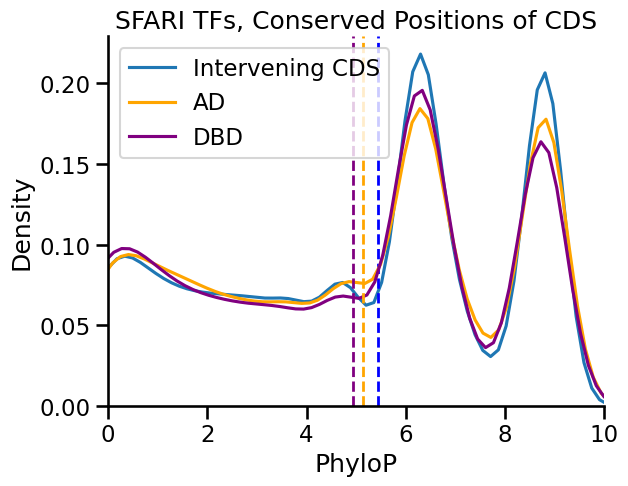

In [28]:
bins = np.arange(-10, 10.1, 0.5)
sns.kdeplot(data = cds_phylo_P_to_merge_no_dom, x = "PhyloP", label = "Intervening CDS")
plot_mean(cds_phylo_P_to_merge_no_dom, "b", lw = 2)

sns.kdeplot(data = ad_phylo_P, x = "PhyloP", color = "orange", label = "AD")
plot_mean(dbd_phylo_P, 'purple', lw = 2)

sns.kdeplot(data = dbd_phylo_P, x = "PhyloP", color = "purple", label = "DBD")
plot_mean(ad_phylo_P, 'orange', lw = 2)

plt.title("SFARI TFs, Conserved Positions of CDS")
plt.legend()
plt.xlim(0, 10)
sns.despine();

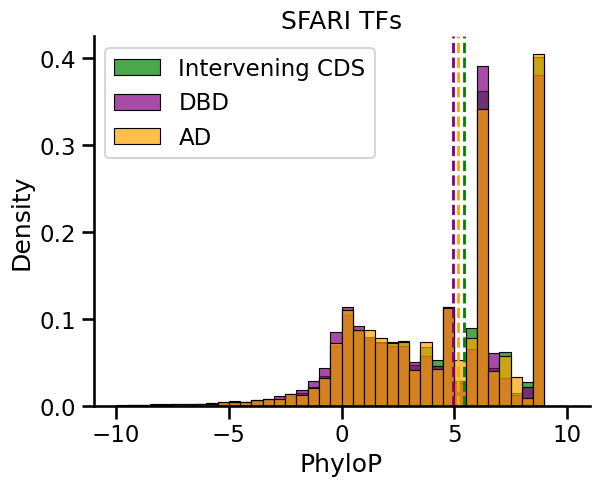

In [29]:
sns.set_context('talk')

bins = np.arange(-10, 10.1, 0.5)

sns.histplot(data = cds_phylo_P_to_merge_no_dom, x = "PhyloP", bins = bins, stat = "density", color = "green", label = "Intervening CDS", alpha = 0.7)
plot_mean(cds_phylo_P_to_merge_no_dom, 'green')

#sns.histplot(data = df_cds_no_ad, x = "PhyloP_x", bins = bins, stat = "density")
sns.histplot(data = dbd_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "purple", label = "DBD", alpha = 0.7)
plot_mean(dbd_phylo_P, 'purple')

sns.histplot(data = ad_phylo_P, x = "PhyloP", bins = bins, stat = "density", color = "orange", label = "AD", alpha = 0.7)
plot_mean(ad_phylo_P, 'orange')


plt.title("SFARI TFs")
plt.legend()
sns.despine();

In [30]:
cds_phylo_P_to_merge.to_csv("../output/SFARI_TFs_cds_phyloP.csv")